## Estimating statistical errror bars with Jackknife resampling

This test shows how to extract the second Renyi entropy $S_2=\mathrm{Tr}(\rho^2)$ and the associated error bars.

In [4]:
using RandomMeas

First we load in memory a random quantum state and calculates the purities accross different cuts

In [5]:
N  = 6 #number of qubits
χ = 2^(N÷2) #a large bond-dimension to consider a typical random state
ξ = siteinds("Qubit", N)
ψ = random_mps(ξ; linkdims=χ);

S = [-log2(get_moment(get_spectrum(ψ,NA),2)) for NA in 1:N] 
println("Entropies ", S);

Entropies [0.27727894732256264, 0.7114703417185682, 1.263139190504785, 1.6075946722881465, 0.9199827616449141, -3.844111804577896e-15]


Then we sample randomized measurements 

In [9]:
using ProgressMeter

ITensors.disable_warn_order()
nu = 400
NM = 400
data = zeros(Int,(nu,NM,N))
u = Vector{Vector{ITensor}}()
@showprogress dt=1 for r in 1:nu
    push!(u,get_rotations(ξ,"Haar")) #Haar rotations in A
    data[r,:,:] = get_RandomMeas(ψ,u[r],NM,"dense")
end

[Jackknife resampling](https://en.wikipedia.org/wiki/Jackknife_resampling) provides a simple method to estimate statistical errors when estimating a physical quantity from a single dataset. The helper function below returns the Jackknife estimation of the statistical error for an estimator evaluated on a vector of $n_s$ samples. The function provides also an approximate unbiased evaluation of the estimator. 

In [10]:
using Statistics

function jackknife(estimator,samples)
    ns = length(samples)
    θ = zeros(Float64,ns)
    for i in 1:ns
        θ[i] = estimator(samples[1:end .!= i])
    end
    θ_est = ns*estimator(samples)-(ns-1)*mean(θ) #approximate unbiased estimator
    var_est = var(θ)* (ns - 1)^2 / ns #approximate statistical variance 
    return θ_est, sqrt(var_est)
end

jackknife (generic function with 1 method)

We can then apply this method for a purity estimation based on batch shadows [Rath et al, PRX quantum 2023](https://doi.org/10.1103/PRXQuantum.4.010318).
Note that Jacknife methods requires evaluating the estimator $n_s$ times, so we use here a small number $n_s=40$ of batch shadows to obtain a result in a reasonable time.

In [11]:
ns = 40 #number of batches
S_est = zeros(Float64,N)
σ= zeros(Float64,N)
@showprogress dt=1 for NA in 1:N
    uA = [ut[1:NA] for ut in u]
    ξA = ξ[1:NA]
    ρs = get_batch_shadows(data[:,:,1:NA],ξA,uA,ns);
    estimator(x) = -log2(get_moment(x, ξA, 2))

    S_est[NA], σ[NA] = jackknife(estimator,ρs)
end   

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


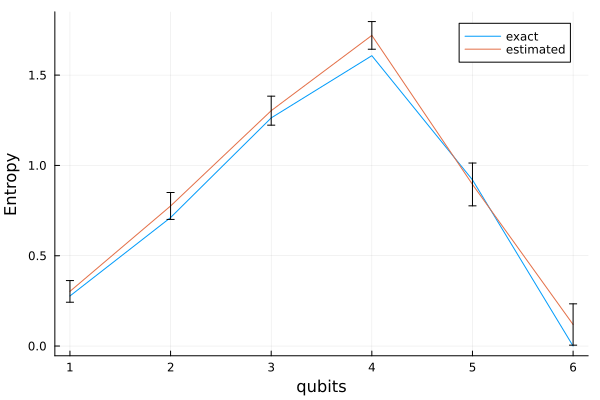

In [12]:
using Plots
plot(1:N,S,label="exact")
plot!(1:N,S_est,yerr = σ,label="estimated")

ylabel!("Entropy")
xlabel!("qubits")